# Building an image classifier using Fastai V2
> Harnessing the power of fastai to build state-of-the-art deep learning models.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Harish Vadlamani
- categories: [fastai, image classification]


---

I would like to start these series of posts with an introduction to the [fastai v2](http://dev.fast.ai) library in the application of vision, which is arguably the most common application in the field, and definitely, the most worked on. 

---


### Importing the library and necessary modules

In [1]:
from fastai.vision.all import *
%matplotlib inline

***Note:*** The first line imports some helper functions from utils.py as used in the [fastbook](https://github.com/fastai/fastbook) repo which provides great visualization options. 

---
### About the dataset
Let's start with the Flowers [dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/), which is a common dataset for image classification tasks. The dataset is a collection of images of 102 different types of flowers, which is nicely curated. The images are of fairly reasonable size shot in different angles and lighting conditions.

Here's a [list](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html) of the 102 different categories of flowers in this dataset for your reference.

---
### Getting and exploring the dataset

Now that we have our arsenal set up and have an understanding of the data we are working. Let's download it and explore it.

About 90% of the work done by data scientist revolves around clearly gathering data. For simplicity, let's begin with commonly available datasets.

Fastai library makes it extremely easy to get common well-know [datasets](http://dev.fast.ai/data.external.html)  and is stored in Amazon S3 buckets for fast retrieval and use. They're all stored in the `URLs` global constant.

In [2]:
flowers_link = URLs.FLOWERS
flowers_link

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz'

In [3]:
path = untar_data(flowers_link)
path.ls()

(#4) [Path('/home/harish/.fastai/data/oxford-102-flowers/jpg'),Path('/home/harish/.fastai/data/oxford-102-flowers/test.txt'),Path('/home/harish/.fastai/data/oxford-102-flowers/train.txt'),Path('/home/harish/.fastai/data/oxford-102-flowers/valid.txt')]

The above response may appear like a datastructure similar to a list in Python, but it's a built-in fastai data structure called 'L.' You can think of it as a data structure, which is an amalgamation of lists and dicts in Python.

The above output begins with a tuple '#4', which indicates that the path has 4 sub-directories in it and then displays those directories as an array.

To see the directories better, let's just see the base path of the sub directories instead of the entire path.

In [4]:
Path.BASE_PATH = path
path.ls()

(#4) [Path('jpg'),Path('test.txt'),Path('train.txt'),Path('valid.txt')]

In [5]:
# !pip install tree
!tree -d {path}

/home/jupyter/.fastai/data/oxford-102-flowers
└── jpg

1 directory


Now we can clearly see that the directory has one folder and three .txt files:

- jpg: A folder containing all the images of the dataset
- txt files: 3 text files indicating train, test, and validation. 

Let's look into the 'jpg' folder:

Fastai provides an in-built function, `get_image_files` to get all image files in a folder as an 'L'.

In [5]:
files = get_image_files(path/'jpg')
files

(#8189) [Path('jpg/image_03860.jpg'),Path('jpg/image_05075.jpg'),Path('jpg/image_01217.jpg'),Path('jpg/image_06190.jpg'),Path('jpg/image_04181.jpg'),Path('jpg/image_03936.jpg'),Path('jpg/image_06732.jpg'),Path('jpg/image_01810.jpg'),Path('jpg/image_01316.jpg'),Path('jpg/image_00586.jpg')...]

We can see that there are 8189 images in the dataset available to us. Let's look at one of the images.

<AxesSubplot:>

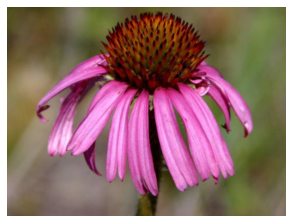

In [6]:
img = PILImage.create(files[0])
img.show()

Now let's look at the .txt files using pandas. Pandas is the go-to method for dealing with a tabular structure in python and is an essential skill for all data scientists using python. 

Pandas can read many formats of data such as CSV, Excel, as well as text files very quickly by creating a pandas dataframe for manipulating it accordingly. 

In [7]:
train = pd.read_csv(path/'train.txt', header=None, sep=' ')
train.head() #head displays the first 5 rows of the dataframe

,0,1
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


We can see that the file contains the image file name and its corresponding labels. So let's label the columns of the pandas dataframe accordingly.

In [8]:
cols = ['name', 'label']
train.columns = cols
train.head()

,name,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


Now that we have an organized structuring for our training files. Let's do the same to create a validation and test dataframe.

In [9]:
# validation df
valid = pd.read_csv(path/'valid.txt', sep=" ", names= cols )
# test df
test = pd.read_csv(path/'test.txt', sep=" ", names= cols )

In [10]:
valid.head()

,name,label
0,jpg/image_04467.jpg,89
1,jpg/image_07129.jpg,44
2,jpg/image_05166.jpg,4
3,jpg/image_07002.jpg,34
4,jpg/image_02007.jpg,79


In [11]:
test.head()

,name,label
0,jpg/image_06977.jpg,34
1,jpg/image_00800.jpg,80
2,jpg/image_05038.jpg,58
3,jpg/image_06759.jpg,0
4,jpg/image_01133.jpg,45


Let's see the count of images in each one of the train, validation and test datasets. 

In [12]:
print(f"The number of images in training set are:{len(train)}")
print(f"The number of images in validation set are:{len(valid)}")
print(f"The number of images in test set are:{len(valid)}")

The number of images in training set are:1020
The number of images in validation set are:1020
The number of images in test set are:1020


We can see that we have a total of around 8000 labelled images to build our flower classifier of 102 different clases. Since the data we have ain't that much let's utilize all the data available to build our model. To do so let's first merge the 3 dataframes into one.


In [13]:
df = pd.concat([train, valid, test], axis=0)
df.head()

,name,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


In [14]:
#hide_input
print(f'The main dataframe consists of {len(df)} labeled images.')

The main dataframe consists of 8189 labeled images.


By looking at the above dataframe we can see that the images and numerically labelled by the creators of the datset, probably for easier mapping. This would make visualization pretty bad since we won't what flower we are seeing in the end. So let's get the mpping of the labels to the numerical assignemnt given here.

If you look at the main source of the dataset, the labels are provided in a .mat file and would be quite cumbersome to fetch. Luckily enough [JosephKJ](https://gist.github.com/JosephKJ) did the labelling and generously made it available for us [here](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1). I downloaded the .txt file and will read it using pandas. 

In [15]:
labels = pd.read_csv('data/labels.txt', header=None, names = ['labels'])
labels['labels'] = labels['labels'].apply(lambda x: x.replace("'", ""))
labels.head()

,labels
0,pink primrose
1,hard-leaved pocket orchid
2,canterbury bells
3,sweet pea
4,english marigold


Now creating labels dictionary where key is the number and value is the respective name of the flower. 

In [16]:
labels_dict = dict(zip(list(range(len(labels))), labels['labels']))

Let's use the all powerful pandas `apply` function again to map the numerical labels in `df` with the `labels_dict`

In [17]:
# Creating a new column 'class' using the existing label of images
df['class'] = df['label'].apply(lambda x: labels_dict[x])
df.head()

,name,label,class
0,jpg/image_03860.jpg,16,purple coneflower
1,jpg/image_06092.jpg,13,spear thistle
2,jpg/image_02400.jpg,42,sword lily
3,jpg/image_02852.jpg,55,bishop of llandaff
4,jpg/image_07710.jpg,96,mallow


Let's now save this dataframe  as a CSV file for ease of access later on.

In [18]:
df.to_csv('data/df.csv')

Now that we have arranged our data exactly as we want it, let's move ahead to model building using fastai library. 

---

### The DataBlock API

We have our data structured well and exactly as we want. It's now time to feed it into the fastai library. This can be done using the [DataBlocks](http://dev.fast.ai/data.block) API. 

> The DataBlocks API is the Fastai solution to simplifying the most time-consuming task in a data science pipeline, `Data Preparation.` It's easy to use, highly hackable and can be be used for a wide variety of data on applications such as vision, tabular, and text. 

This DataBlock API is a much-needed addition to the fastai v2, which makes it super easy to load in data as needed for deep learning models.

In [19]:
def get_x(r): return path/r['name']
def get_y(r): return r['class']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x= get_x,
                   get_y= get_y, 
                   item_tfms = Resize(224))
dls = dblock.dataloaders(df) 

Let's get a basic understanding of what's happening in the above code. Creating data which can be fed to a model requires two steps:

#### 1. Create a DataBlock: 

A `Datablock` can be considered as a series of sequential functions all collated into one function. For people who have used sci-kit-learn, this can be considered similar to a pipeline. 

The DataBlock API requires some methods to get the input data in the desired format for model building and training:

- `blocks`: 
This is used to define the input and output of the model. In the above code, the type of input i.e. the independent variable, which are images and hence `ImageBlock.` The output, i.e., dependant variable, are categories of flowers and hence `CategoryBlock.`
    
- `splitter`: 
Splitters are used to divide our data into training and validation. This is of utmost importance because we don't want our model to train and memorize all the training images. We want a subset of images to validate how good our model is doing. In this case, we use a method that randomly splits data in train and validation. 
    
- `getters`:
Getters are used to get the independent and dependant variables in the right order. The two getters used are `get_x` and `get_y.` Here we defined `get_x` by grabbing the name of the image file from `df` and adding the path to it, and we set `get_y` by getting the `class` column from df. 
    
- `transforms`: 
Transforms are used to perform data augmentation techniques on our input data either on the entire data(`item_tfms`) on the CPU or on the data passed as batches(`batch_tfms`) when passing it through the architecture on the GPU. In this case, we are just resizing all images to `224`, which is mandatory as deep learning models need all our training images to be of the same size. 
    
    
#### 2. Call the dataloaders method on your data:

A `dataloaders` is a method called on the DataBlock where we pass in our dataframe `df` to perform all the steps mentioned in the DataBlock, which finally returns the data in the required format for modeling. 

---
### Visualizing the data

Now that we have made our data ready and in the format to be ingested by the fastai library, let's visualize our data. 

We can use `show_batch` method from our dataloader created to visualize a batch of images and their labels.

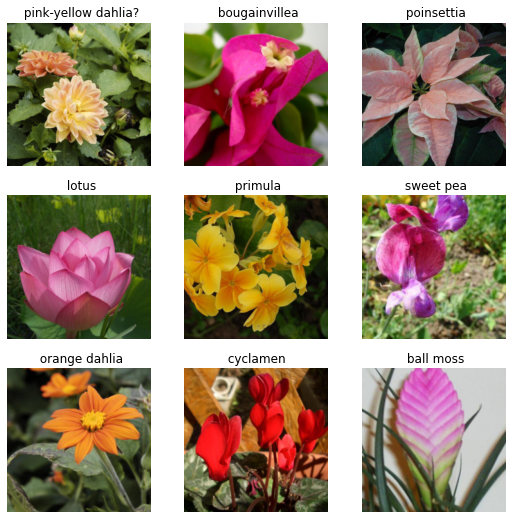

In [20]:
dls.show_batch()

---
### Building the model

Let's build a deep learning model on our dataset using a ***Convolutional Neural Netwok(CNN)*** model. 


#### Basic understanding of CNN's

Here's the general architecture of every CNN model

![](images/cnn_understanding.jpeg)

Every CNN architecture consists of 4 parts:

- Input layer: 
    The input i.e. the image dataset with 'n' classes which are correctly labeled on which our image classification model is built on. 
    
- Feature extraction: 
    This is the crux of the CNN model. It learns various features of the classes in your data and how to distinguish between them during the training process. 
    For instance, during the training process, if images of dogs are passed in, the initial layers learn simple features such as lines, edges, circles. Still, as we move to later layers of the model, the model learns complex features like ears, nose, and eyes of the dog. In machine language, all these features are represented numerically, and we refer to all these learned features as `parameters` of the model. 
    
- Classification:
    This part of the model is used to pool in the different features learned and associate it with the corresponding class. 
    Continuing the example of our dog, it could mean that we pool in the features learned about the dog, such as its nose, eyes, tail, etc. and associate it with the output label, which is a dog.
   
- Output:
    This is the part that associates an input image to class as labeled in our training set. When a new image of a dog is sent through a trained model, the output class of the model will get activated and indicate that the input image is that of a dog. 
    
The entire structure of the model built above is referred to as a model `architecture` in deep learning. 


Now, we can build flower classifier from scratch, but since we only have 8000 odd images for 102 different classes. We can safely say that we don't have enough data to build a beautiful model from scratch. 

Instead, let's use the biggest weapon in the deep learning arsenal available at our disposal, ***Transfer Learning***. 

---
#### Transfer Learning

Transfer Learning is a method that uses the work done by other researchers who spend days on end to build appropriate `architectures` which train on large datasets for specific tasks. For instance, the ImageNet dataset, which consists of  1.3 million images of various sizes around 500 pixels across in 1000 categories, takes a few days to train. 

The main idea is as follows, the ImageNet dataset has 1000 different everyday categories, and the parameters and features it learns for each one of the categories can be applied to make the building blocks of the flowers dataset we are working on. The initial ***feature extraction*** layers that learn simple features line lines, edges, circles, etc. can be applied to flowers as well, and we can fine-tune the final layers to distinguish between the different classes of flowers. 

The final output layer(which is trained on 1000 categories) also needs to be removed and replaced with the 102 different classes of flowers. 

---
#### Defining the learner

In fastai, to build a model, we use the `cnn_learner` class. We need to pass in the following details to the `cnn_learner` to train the model:

- ***Dataloaders object:***
   The `dls` dataloader we created according to how fastai needs the input data.  
- ***Model Architecture:***
    This is the architecture we would like to use. Since we are making use of transfer learning, we'll use a `pretrained model,` in this case, the famous resnet34 architecture. 
- ***Metrics:***
    This is how you would like to keep track of your training progress. In this case, we'll use `accuracy,` which indicates how well our model classifies all the classes in our data overall. 

In [21]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/harish/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Let's visualize the model architecture used i.e the resnet34 architecture

In [ ]:
learn.summary()

If you scroll down and read the summary, in the end, you can see that there are a total of around 21 million parameters, but only around 600k parameters are trainable. 

This is because we have inherited a model trained extensively on the ImageNet dataset and are using the parameters learned by that model to train our model on 102 classes of flowers. 

This means that the parameters learned early on in the model to distinguish various objects are kept as is, and the final layers are replaced to classify.

#### Fine-tuning pretrained model

Once we have created our learner based on a pretrained resnet34 model, let's train our learner on classifying the flowers. In fastai there's a learner method specifically to train a pretrained model called `fine_tune` quickly. 

`fine_tune` by default trains the `head,` i.e. the additional part to the model we added for our classification of 102 flowers for one epoch and then unfreezes the all the weights and optimizes the entire model including the weights in the starting phase. 

So in the first epoch, the model learns the 600k trainable parameters such that all 21 million parameters are trained roughly. In the consecutive 2 epochs, it optimizes the all these weights specifically for the task in hand, i.e. classifying 102 types of flowers.  

In [ ]:
learn.fine_tune(3)

We can see that by using the power of transfer learning, in 2 lines of code and 3 steps of training(epochs) which took about 30 seconds to train on small GPU we are able to build a flowers classifier which can classify between 102 types of flowers with greater than 96% accuracy! 

This blows the original [paper](https://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/nilsback08.pdf) out of the water which came out in 2008 which used a non-DL approach to tackle this problem and received an accuracy of about 72.8%

![](images/og_flowers_results.png)

But this isn't really a fair comparison, so if we compare our basic model the current [leaderboard](https://paperswithcode.com/sota/image-classification-on-flowers-102) for the flowers-102 dataset, we can see that the best accuracy on the entire dataset is about 99.7%. 

So, this is a good starting point. This will act as our baseline model for future improvements and experimentation in order to come closer to the current benchmark. 

So let's save this model so that we can build on from here form next time. 

In [ ]:
learn.save('flowers-baseline')

We'll slowly build upon this and make this model better while learning more about building state-of-the-art models in the upcoming posts.

---
### Learning resources

1. Corey Schafer's [Python Tutorials](https://www.youtube.com/watch?v=YYXdXT2l-Gg&list=PL-osiE80TeTt2d9bfVyTiXJA-UTHn6WwU)
2. Corey Schafer's [Pandas Tutorials](https://www.youtube.com/watch?v=ZyhVh-qRZPA&list=PL-osiE80TeTsWmV9i9c58mdDCSskIFdDS)
3. Fastai v2 [Documentation]()

4. [Fastbook](https://github.com/fastai/fastbook) i.e Deep Learning for Coders with Fastai and Pytorch: AI Applications Without a PhD by Jeremy Howard and Sylvain Gugger

5. [Fastai DataBlock API walkthrough](https://t.co/b1ZFLpJ1DN?amp=1) blog by [Zach Mueller](https://forums.fast.ai/u/muellerzr/summary)

---

Happy learning, stay at home and stay safe! :)

---